In [1]:
import torch
import torchvision.transforms as T
from diffusers import StableDiffusionPipeline, DDIMScheduler, AutoencoderKL, KandinskyV22PriorPipeline
from PIL import Image

from src.ip_adapter import IPAdapter

In [2]:
import torch
from torch.utils.data import DataLoader
from diffusers import StableDiffusionPipeline, DDIMScheduler, AutoencoderKL, KandinskyV22PriorPipeline
from accelerate.utils import set_seed
from PIL import Image
import pandas as pd
import os

from torchmetrics.multimodal.clip_score import CLIPScore
from torchmetrics.image.fid import FrechetInceptionDistance
from torchmetrics.image import StructuralSimilarityIndexMeasure, MultiScaleStructuralSimilarityIndexMeasure
from tqdm.notebook import tqdm

from src.dataset import MetricsDataset

from src.ip_adapter import IPAdapter

In [3]:
base_model_path = 'dreamlike-art/dreamlike-anime-1.0'
vae_model_path = "stabilityai/sd-vae-ft-mse"
image_encoder_path = "/home/chaichuk/Annual_Project/IP-Adapter/models/image_encoder"
ip_ckpt = "/home/chaichuk/Annual_Project/weights/512_res_model/checkpoint-100/ip_adapter.bin"
device = "cuda:0"

In [4]:
def image_grid(imgs, rows, cols):
    assert len(imgs) == rows*cols

    w, h = imgs[0].size
    grid = Image.new('RGB', size=(cols*w, rows*h))
    grid_w, grid_h = grid.size
    
    for i, img in enumerate(imgs):
        grid.paste(img, box=(i%cols*w, i//cols*h))
    return grid

noise_scheduler = DDIMScheduler(
    num_train_timesteps=1000,
    beta_start=0.00085,
    beta_end=0.012,
    beta_schedule="scaled_linear",
    clip_sample=False,
    set_alpha_to_one=False,
    steps_offset=1,
)
vae = AutoencoderKL.from_pretrained(vae_model_path).to(dtype=torch.float16)

In [5]:
pipe = StableDiffusionPipeline.from_pretrained(
    base_model_path,
    torch_dtype=torch.float16,
    scheduler=noise_scheduler,
    vae=vae,
    feature_extractor=None,
    safety_checker=None
)

Loading pipeline components...:   0%|          | 0/5 [00:00<?, ?it/s]

In [6]:
ip_model = IPAdapter(pipe, image_encoder_path, ip_ckpt, device)

/home/chaichuk/Annual_Project/Team73-Annual-Project/src/ip_adapter/ip_adapter.py:134: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(self.ip_ckpt, map

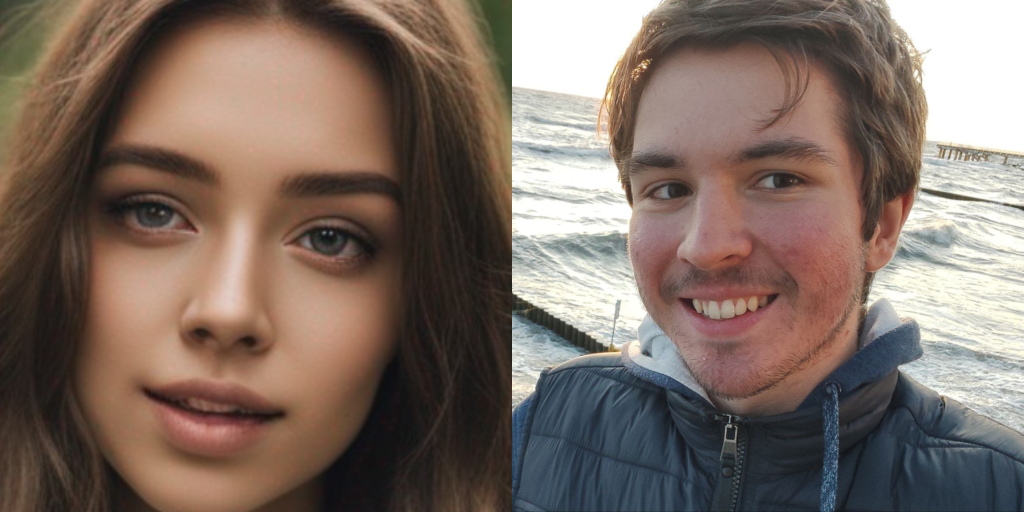

In [7]:
resize = T.Resize(512)

image = resize(Image.open("./assets/images/ai_face.png").convert('RGB'))
image2 = resize(Image.open("./assets/images/literally_me.jpg").convert('RGB'))

image_prompts = [image, image2]
image_grid(image_prompts, 1, 2)

  0%|          | 0/50 [00:00<?, ?it/s]

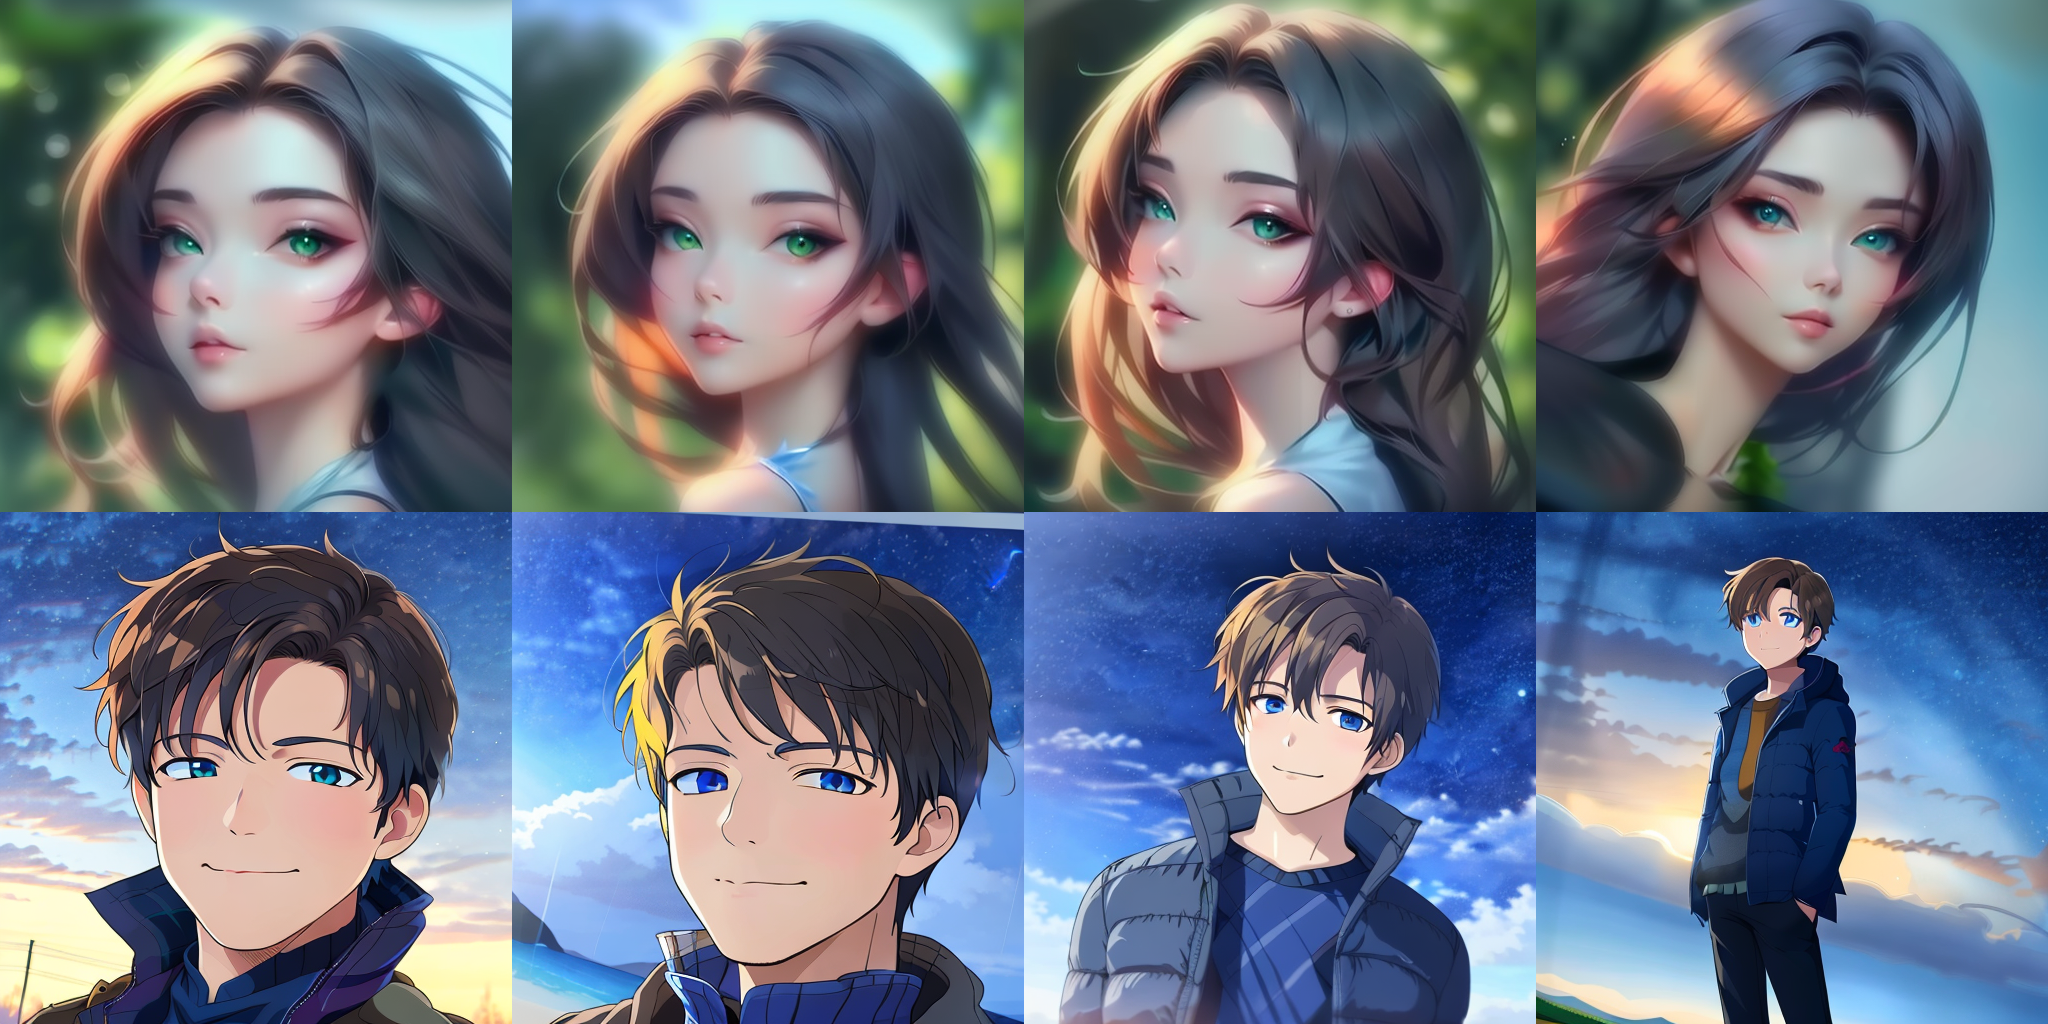

In [8]:
images = ip_model.generate(pil_image=image_prompts, prompt='anime style', num_samples=4, height=512, width=512, num_inference_steps=50, scale=0.8)
image_grid(images, 2, 4)